In [4]:
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV

In [5]:

# Load the dataset from a CSV file
csv_file_path = '../dataset/heart.csv'
data = pd.read_csv(csv_file_path)


In [6]:

# Define the parameter grid
param_grid = {
    'hidden_layer_sizes': [(100,), (100, 50,), (200, 50,), (200,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant', 'adaptive'],
}

# Assume the target column is named 'target' and the rest are features
X = data.drop(columns=['target'])
y = data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Initialize the MLPClassifier
mlp = MLPClassifier(max_iter=300, random_state=1)

# Perform grid search
grid_search = GridSearchCV(mlp, param_grid, n_jobs=-1, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Best parameters and best score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best accuracy: {grid_search.best_score_:.2f}")

# Use the best estimator to predict
best_mlp = grid_search.best_estimator_
y_pred = best_mlp.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test set accuracy with best parameters: {accuracy:.2f}")

Best parameters: {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (200, 50), 'learning_rate': 'constant', 'solver': 'adam'}
Best accuracy: 0.90
Test set accuracy with best parameters: 0.82


In [28]:

# Function to plot learning curve
def plot_manual_learning_curve(X_train, X_test, y_train, y_test, model, train_sizes=np.linspace(0.1, 1.0, 10)):
    # Initialize lists to store scores
    train_scores = []
    test_scores = []

    # Loop over different training sizes
    for train_size in train_sizes:
        # Determine the subset size
        subset_size = int(train_size * len(X_train))

        # Create subsets of the training data
        X_train_subset = X_train[:subset_size]
        y_train_subset = y_train[:subset_size]

        # Train the model on the subset
        model.fit(X_train_subset, y_train_subset)

        # Evaluate on the training subset
        train_pred = model.predict(X_train_subset)
        train_score = accuracy_score(y_train_subset, train_pred)
        train_scores.append(train_score)

        # Evaluate on the full test set
        test_pred = model.predict(X_test)
        test_score = accuracy_score(y_test, test_pred)
        test_scores.append(test_score)

    # Convert scores to numpy arrays for easier handling
    train_scores = np.array(train_scores)
    test_scores = np.array(test_scores)

    # Plot the learning curve
    plt.figure()
    plt.title("Learning Curve (MLPClassifier)")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.grid()

    plt.plot(train_sizes * len(X_train), train_scores, 'o-', color="r", label="Training Accuracy")
    plt.plot(train_sizes * len(X_train), test_scores, 'o-', color="g", label="Validation Accuracy")

    plt.legend(loc="best")
    plt.show() 

c:\Users\nicho\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\nicho\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


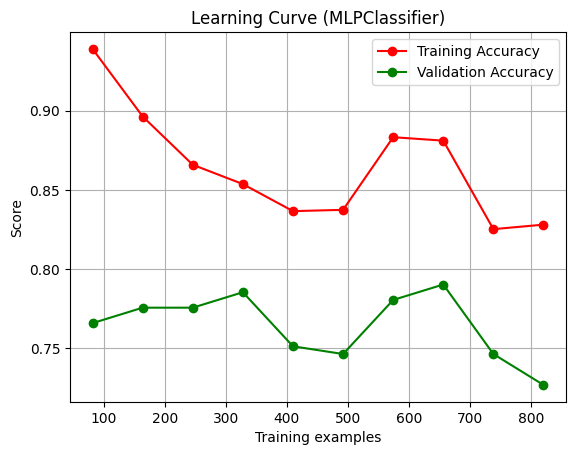

In [29]:

# Initialize the MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, activation='relu', solver='adam', random_state=1)

# Plot learning curve
plot_manual_learning_curve(X_train, X_test, y_train, y_test, mlp)
plt.show()